In [0]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [0]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'
education_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/adult_education_level.csv'

inds_df = pd.read_csv(indicators_url)
ed_df = pd.read_csv(education_url)

# Column 9999 in the Indicators Dataset only shows the latest value from the data drawn within 1990 to 2017.
# In order to detect education system growth predictors this column is unneccessary.
inds_df = inds_df.drop(columns=['9999'])

In [4]:
# Many indicators from 1990 to 2017 that only have at most one or two recordings for a specific indicators.
# These recordings may or may not indicate growth over the years which will not contribute to our analysis.
# These indicators will be dropped.
# When threshold = 1, it removed 25636 - 20588 = 5048 / 25636 = 20% of the indicators
threshold = 20
drop_stack = set()
print(len(inds_df))
for index, row in inds_df.iterrows():
#     print(row['1990':].count())
    if row['1990':].count() <= threshold:
        drop_stack.add(index)
inds_df = inds_df.drop(drop_stack)
print(len(inds_df))


25636
6242


In [0]:
# Get the missing values at each year and return the array of years (aka. column)
def get_missing_yearly_values(row):
    row_df = row.to_frame().reset_index()
    row_df = row_df.drop(range(5))
    row_df.columns = ['x', 'y']
    missing_X = row_df[row_df['y'].isnull()].x
    return missing_X

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
year_columns = inds_df.columns.values[5:]
for index, row in inds_df.iterrows():
    missing_years = get_missing_yearly_values(row).values
    # If there are nothing to fill out then we don't need to model it out.
    if missing_years.size <= 0:
        continue
    row = row.drop(missing_years)
    row = row.drop(['dimension', 'indicator_id', 'indicator_name', 'iso3', 'country_name'])
    value = row.values.reshape(-1, 1)
    year = year_columns
    # The difference set of total years and missing years are the years where there are recorded values.
    year = np.setdiff1d(year, missing_years).astype(int).reshape(-1, 1)
    missing_years = missing_years.astype(int)
    missing_years = missing_years.reshape(missing_years.shape[0],-1)
    
    reg = LinearRegression()
    reg.fit(year, value)
    missing_values = reg.predict(missing_years)
    # Filling out the missing data
    for i in range(len(missing_years)):
        inds_df.at[index, str(missing_years[i][0])] = missing_values[i][0]
        

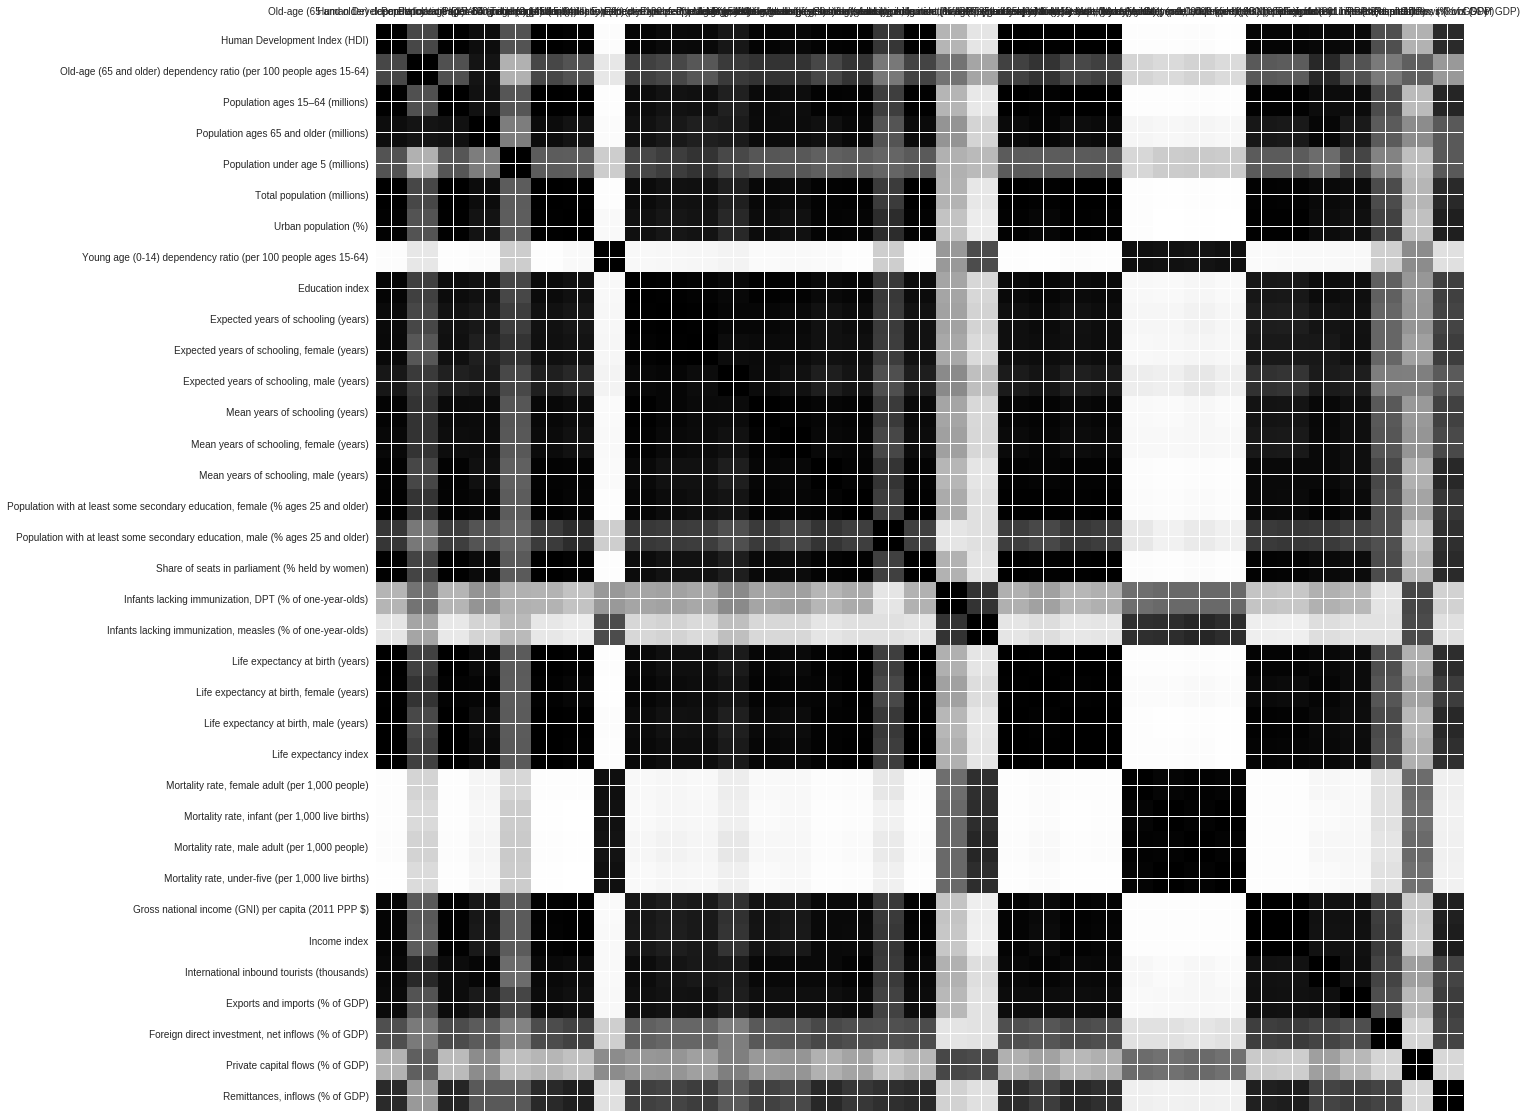

In [7]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
country_names = inds_df.country_name.unique()
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rops
  df_corr = df_corr[2:]
  # df_corr = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1).drop(inds_df.columns[range(5,32)], axis=1)[inds_df.country_name == "Albania"]
  df_corr = df_corr.apply(pd.to_numeric)
  # print(df_corr.corr())
  plot_corr(df_corr, size=20)

# change threshold to get more columns 
plot_corr_country(inds_df, "United States")